In [1]:
import numpy as np
import scipy.constants as cc
from scipy import linalg

from tabulate import tabulate

import matplotlib.pyplot as plt

import itertools

from RachbaJunction import RachbaJunction
from RachbaJunction.utilities import *

ModuleNotFoundError: No module named 'RachbaJunction'

# naive matching

In [16]:
ee = 0
E = ee
x = 0
# al_r = 8
# alpha = [-al_r, al_r]

al_r = 4
alpha = [-al_r, al_r-3]

profile = [0]

junction = RachbaJunction([profile, alpha])

junction.E_so = junction.alpha_profile[0]
junction.prepare_rashba_WF(x, E)

i = 0
b1 = -junction.omega_k(x, junction.wave_length[i], junction.band[i])[0]
b2 = -junction.omega_k(x, junction.wave_length[i], junction.band[i])[1]
b3 = (np.sign(junction.wave_length[i][1])*np.sqrt(junction.E_0(E, junction.l[i], junction.mod[i])) 
      - junction.sgn_alpha * np.sqrt(junction.E_so))* b1
b4 = (np.sign(junction.wave_length[i][1])*np.sqrt(junction.E_0(E, junction.l[i], junction.mod[i])) 
      + junction.sgn_alpha * np.sqrt(junction.E_so))* b2

i = 1
m11 = junction.omega_k(x, junction.wave_length[i], junction.band[i])[0]
m21 = junction.omega_k(x, junction.wave_length[i], junction.band[i])[1]
m31 = (np.sign(junction.wave_length[i][1])*np.sqrt(junction.E_0(E, junction.l[i], junction.mod[i])) 
           - junction.sgn_alpha * np.sqrt(junction.E_so))* m11
m41 = (np.sign(junction.wave_length[i][1])*np.sqrt(junction.E_0(E, junction.l[i], junction.mod[i])) 
            +junction.sgn_alpha * np.sqrt(junction.E_so))* m21

i = 2
m12 = junction.omega_q(x, junction.wave_length[i], junction.band[i])[0]
m22 = junction.omega_q(x, junction.wave_length[i], junction.band[i])[1]
m32 = -(complex(0, np.sign(junction.wave_length[i][1])) *np.sqrt(junction.E_0(E, junction.l[i], junction.mod[i])) 
        + junction.sgn_alpha * np.sqrt(junction.E_so))* m12
m42 = -(complex(0, np.sign(junction.wave_length[i][1])) *np.sqrt(junction.E_0(E, junction.l[i], junction.mod[i]))
        - junction.sgn_alpha * np.sqrt(junction.E_so))* m22

junction.E_so = junction.alpha_profile[1]
junction.prepare_rashba_WF(x, E)

i = 0
m13 = -junction.omega_k(x, junction.wave_length[i], junction.band[i])[0]
m23 = -junction.omega_k(x, junction.wave_length[i], junction.band[i])[1]
m33 = (np.sign(junction.wave_length[i][1])*np.sqrt(junction.E_0(E, junction.l[i], junction.mod[i])) 
       - junction.sgn_alpha * np.sqrt(junction.E_so))* m13
m43 = (np.sign(junction.wave_length[i][1])*np.sqrt(junction.E_0(E, junction.l[i], junction.mod[i])) 
       + junction.sgn_alpha * np.sqrt(junction.E_so))* m23

i = 3
m14 = -junction.omega_q(x, junction.wave_length[i], junction.band[i])[0]
m24 = -junction.omega_q(x, junction.wave_length[i], junction.band[i])[1]
m34 = -(complex(0, np.sign(junction.wave_length[i][1])) *np.sqrt(junction.E_0(E, junction.l[i], junction.mod[i])) 
        + junction.sgn_alpha * np.sqrt(junction.E_so))* m14
m44 = -(complex(0, np.sign(junction.wave_length[i][1])) *np.sqrt(junction.E_0(E, junction.l[i], junction.mod[i]))
        - junction.sgn_alpha * np.sqrt(junction.E_so))* m24


In [21]:
s1 = np.array([[m11, m12, m13, m14], [m21, m22, m23, m24], [m31, m32, m33, m34], [m41, m42, m43, m44]])
b = np.array([b1, b2, b3, b4])

inv_s1= linalg.inv(s1)
match_coeff = np.dot(inv_s1, b)
# match_coeff = inv_s1.dot(b)


M_tot, vel_factor = junction.get_transfer_matrix(ee)

S = junction.get_scattering_matrix(ee)
S.S = 1/vel_factor * S.S

print(f" left reflected {match_coeff[0]}\n left evanescent {match_coeff[1]}\n\n right reflected {match_coeff[2]}\n right evanescent {match_coeff[3]}")

scater_matrix_iunfo(S.S)

def b_region_WF(x, E, a = [1, 0]):
    
    # left part
    if x <= junction.interface[0]:
        junction.E_so = junction.alpha_profile[0]
        
        junction.prepare_rashba_WF(x, E)
        i = 0
        kk = junction.wave_length[i]
        inject_mode = junction.omega_k(x, kk, junction.band[i])
        
        i = 1
        kk = junction.wave_length[i]
        reflected_mode = match_coeff[0]*junction.omega_k(x, kk, junction.band[i]) 
        #+ S.S[0, 1]*junction.omega_k(x, kk, junction.band[i])
        
        i=2
        kk = junction.wave_length[i]
        ev_mode = match_coeff[1]*junction.omega_q(x, kk, junction.band[i]) 
        #+ S.evanescent_modes[0,1]*junction.omega_q(x, kk, junction.band[i])
        
        res = inject_mode + reflected_mode + ev_mode
        # junction.evanescent_vell_factor*
    elif x > junction.interface[0]:
        junction.E_so = junction.alpha_profile[1]
        junction.prepare_rashba_WF(x, E)
#         i = 1
#         kk = junction.wave_length[i]
        inject_mode = 0#junction.omega_k(x, kk, junction.band[i])
        
        i = 0
        kk = junction.wave_length[i]
        reflected_mode = match_coeff[2]*junction.omega_k(x, kk, junction.band[i]) 
        #+ S.S[1, 1]*junction.omega_k(x, kk, junction.band[i])
        
        i=3
        kk = junction.wave_length[i]
        scale = junction.evanescent_vell_factor*S.evanescent_modes
        ev_mode = match_coeff[3]*junction.omega_q(x, kk, junction.band[i]) 
        #+ S.evanescent_modes[1,1]*junction.omega_q(x, kk, junction.band[i])
        
        res = inject_mode + reflected_mode + ev_mode
    return res

real_1 = []
imag_1 = []

real_2 = []
imag_2 = []

x_range = np.arange(-10, 10, 0.001)
# x_range = np.arange(-2.5, 2.5, 0.001)
for xx in x_range:
    r = b_region_WF(xx, ee)
    real_1.append(r[0].real)
    real_2.append(r[1].real)
    
    imag_1.append(r[0].imag)
    imag_2.append(r[1].imag)

 left reflected (0.2872618648138106+0.8380304452680328j)
 left evanescent (0.2937505007727446-0.36059837940869205j)

 right reflected (0.6230998762647164-0.10092887817134914j)
 right evanescent (1.615176346881408-0.3067200646288218j)
scattering matrix
	real part
--------  -----------
0.287262   0.336518
0.6231    -0.00802823
--------  -----------
	immaginary part
---------  ----------
 0.83803   -0.0545087
-0.100929   0.885861
---------  ----------
inverse vs complex conjugated: True
inverse vs transpose complex conjugated: False



trasmission coefficient: (0,1);(1,0)
0.11621531181009131054
0.39844009425003154107



reflection coefficient:(0,0);(1,1)
0.7848144061724455677
0.7848144061724625343



0.90102971798253687826
1.1832545004224771087
0.9010297179825538449
1.1832545004224771087


In [22]:
%matplotlib notebook

plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(2, 1, figsize=(10, 10), dpi=100, tight_layout=True, facecolor='white')

axs[0].plot(x_range, real_1, label="real part")
axs[0].plot(x_range, imag_1, label="imaginary part")
axs[0].set_title("first spinor component")

axs[1].plot(x_range, real_2, label="real part")
axs[1].plot(x_range, imag_2, label="imagnary part")
axs[1].set_title("second spinor component")

# axs[2].plot(x_range, [i+j for i, j in zip(imag_1, imag_2)], label="phase sum")
# axs[2].plot(x_range, [i+j for i, j in zip(real_1, real_2)], label="norm sum")

fig.suptitle(fr"$$E_{{so}}= ({alpha[0]}, {alpha[1]}) h_\perp, \, E = {ee}$$", fontsize=16)

for i in axs:
    i.legend()
    i.grid(True)
    
plt.savefig("wave function.png", transparent = False)
plt.show()

<IPython.core.display.Javascript object>

# Dirac dilemma regime

## wavefunction plot

In [123]:
ee = 0
# ee = 0

al_r = 10
alpha = [-al_r, al_r]

profile = [0]

junction = RachbaJunction([profile, alpha])
S = junction.get_scattering_matrix(ee)

def b_region_WF(x, E, a = [1, 0]):
    # left part
    if x <= junction.interface[0]:
        junction.E_so = junction.alpha_profile[0]
        wf = junction.get_WF(x, E)
        injected = a[0]*wf[:, 0]
        reflected = np.dot(S.C[:2,:], np.array(a))[0]*wf[:, 1]
        evanescent = np.dot(S.C[2:, :], np.array(a))[0]*wf[:, 2]
    elif x > junction.interface[0]:
        junction.E_so = junction.alpha_profile[1]    
        wf = junction.get_WF(x, E)
        injected = a[1]*wf[:, 1]
        reflected = np.dot(S.C[:2,:], np.array(a))[1]*wf[:, 0]
        evanescent = np.dot(S.C[2:, :], np.array(a))[1]*wf[:, 3]
    return injected + reflected + evanescent

    
real_1 = []
imag_1 = []

real_2 = []
imag_2 = []

x_range = np.arange(-10, 10, 0.1)
# x_range = np.arange(-2.5, 2.5, 0.001)
for xx in x_range:
    r = b_region_WF(xx, ee)
    real_1.append(r[0].real)
    real_2.append(r[1].real)
    
    imag_1.append(r[0].imag)
    imag_2.append(r[1].imag)

<IPython.core.display.Javascript object>


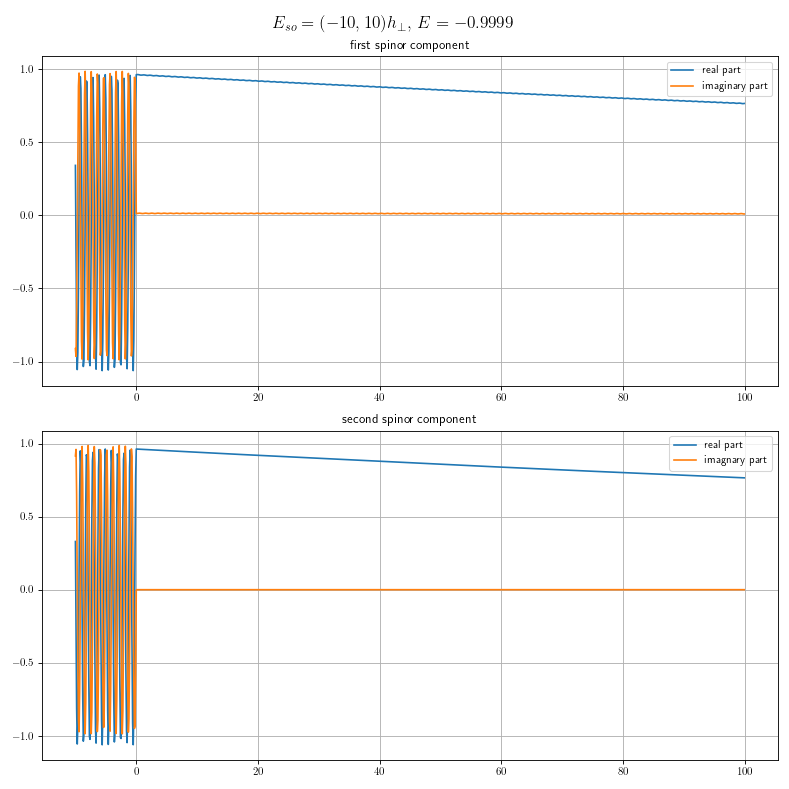

In [124]:
%matplotlib notebook

plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(2, 1, figsize=(10, 10), dpi=100, tight_layout=True, facecolor='white')

axs[0].plot(x_range, real_1, label="real part")
axs[0].plot(x_range, imag_1, label="imaginary part")
axs[0].set_title("first spinor component")

axs[1].plot(x_range, real_2, label="real part")
axs[1].plot(x_range, imag_2, label="imagnary part")
axs[1].set_title("second spinor component")

# axs[2].plot(x_range, [i+j for i, j in zip(imag_1, imag_2)], label="phase sum")
# axs[2].plot(x_range, [i+j for i, j in zip(real_1, real_2)], label="norm sum")

fig.suptitle(fr"$$E_{{so}}= ({alpha[0]}, {alpha[1]}) h_\perp, \, E = {ee}$$", fontsize=16)

for i in axs:
    i.legend()
    i.grid(True)
    
# plt.savefig("wave function.pdf", transparent = False)
plt.show()

## wavefunction for different $E_{so}$

In [48]:
ee = 0
# al_r = 4
# alpha = [-al_r, al_r-3]

al_r = 8
alpha = [-al_r, al_r]

profile = [0]

junction = RachbaJunction([profile, alpha])

def onda1(x, par):
    E = 0
    junction.alpha_profile = [-par[0], par[0]]
    S = junction.get_scattering_matrix(E)
    def b_region_WF(x, E, a = [1, 0]):
        # left part
        if x <= junction.interface[0]:
            junction.E_so = junction.alpha_profile[0]
            wf = junction.get_WF(x, E)
            injected = a[0]*wf[:, 0]
            reflected = np.dot(S.C[:2,:], np.array(a))[0]*wf[:, 1]
            evanescent = np.dot(S.C[2:, :], np.array(a))[0]*wf[:, 2]
        elif x > junction.interface[0]:
            junction.E_so = junction.alpha_profile[1]    
            wf = junction.get_WF(x, E)
            injected = a[1]*wf[:, 1]
            reflected = np.dot(S.C[:2,:], np.array(a))[1]*wf[:, 0]
            evanescent = np.dot(S.C[2:, :], np.array(a))[1]*wf[:, 3]
        return injected + reflected + evanescent
    res = []
    for xx in x:
        r = b_region_WF(xx, E)
        if par[1] == "real":
            res.append(r[0].real)
        elif par[1] == "imag":
            res.append(r[0].imag)
    return res

def onda2(x, par):
    E = 0
    junction.alpha_profile = [-par[0], par[0]]
    S = junction.get_scattering_matrix(E)
    def b_region_WF(x, E, a = [1, 0]):
        # left part
        if x <= junction.interface[0]:
            junction.E_so = junction.alpha_profile[0]
            wf = junction.get_WF(x, E)
            injected = a[0]*wf[:, 0]
            reflected = np.dot(S.C[:2,:], np.array(a))[0]*wf[:, 1]
            evanescent = np.dot(S.C[2:, :], np.array(a))[0]*wf[:, 2]
        elif x > junction.interface[0]:
            junction.E_so = junction.alpha_profile[1]    
            wf = junction.get_WF(x, E)
            injected = a[1]*wf[:, 1]
            reflected = np.dot(S.C[:2,:], np.array(a))[1]*wf[:, 0]
            evanescent = np.dot(S.C[2:, :], np.array(a))[1]*wf[:, 3]
        return injected + reflected + evanescent
    res = []
    for xx in x:
        r = b_region_WF(xx, E)
        if par[1] == "real":
            res.append(r[1].real)
        elif par[1] == "imag":
            res.append(r[1].imag)
    return res

r = [np.arange(-10, 10, 0.01)]
eso = [0.6, 3, 6, 9]
tp = ["real", "imag"]
tp_dict = {"real": 0, "imag": 1}
par = list(itertools.product(eso, tp))

res = make_grid(r, par, [onda1, onda2])
  
    

<IPython.core.display.Javascript object>


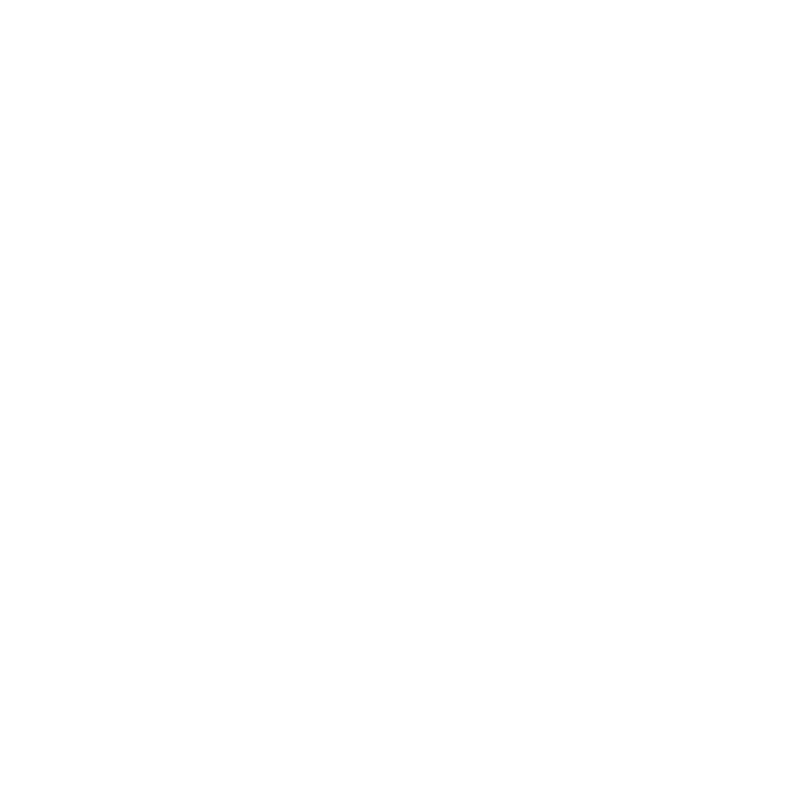

In [63]:
%matplotlib notebook
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(2, figsize=(10, 10), dpi=100, tight_layout=True, facecolor='white')
for eso_to_plot in eso:#[-1]
    for k in res.keys():
        if k[0] == eso_to_plot:
            for i in [0, 1]:
                axs[i].plot(r[0], res[k][i, 0], label=f"{k[1]} part")

                axs[i].set_title(f"{i+1} spinor component")
                axs[i].grid(True)
                axs[i].legend()
        m = tp_dict[k[1]]
    #     axs[k[1] //2 -1 + k[1]%2 *2 , 0].set_title(fr"norm $c_{{k[1]}}$ \n ({modes_dict[k[1]]})")
    #     axs[k[1] //2 -1 + k[1]%2 *2 , 0].set_title(fr"norm $c_{k[1]}$ "+f"\n {m}")
    #     axs[k[1] //2 -1 + k[1]%2 *2 , 0].set_xlabel(r"$E/h_\perp$")
    #     axs[k[1] //2 -1 + k[1]%2 *2 , 0].set_ylabel(fr"$|c_{k[1]}|$", loc = 'top', rotation=0)

    #     axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_title(fr"phase/$\pi$ $c_{k[1]}$ "+f"\n {m}")
    #     axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_xlabel(r"$E/h_\perp$")
    #     axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_ylabel(fr"$\angle c_{k[1]}/\pi$", loc = 'top', rotation=0)


    fig.suptitle(r"$E_{so}/h_\perp = $"+f" {eso_to_plot}", fontsize=16)

    #     for j in i:
    #         j.grid(True)
    #         j.legend()

    plt.savefig(f"wave function (E_so={eso_to_plot}).pdf", transparent = False)
    for i in axs:
        i.cla()
#     plt.show()
plt.close()

## wave functions components

$c_1$ injected from left

$c_2$ reflected from left

$c_3$ evanescent left

$c_4$ reflected right

$c_5$ evanescent right

In [111]:
# ee = 0
ee = -0.9999

al_r = 3
alpha = [-al_r, al_r]

profile = [0]

junction = RachbaJunction([profile, alpha])

def nrm(ee, par):
    junction.alpha_profile = [-par[0], par[0]]
    S = junction.get_scattering_matrix(ee)
#     2 -> 0
#     3 -> 2
#     4 -> 1
#     5 -> 3
    return np.linalg.norm(S.C[par[1] //2 -1 + par[1]%2 *2 ,0])

def ngl(ee, par):
    junction.alpha_profile = [-par[0], par[0]]
    S = junction.get_scattering_matrix(ee)
#     2 -> 0
#     3 -> 2
#     4 -> 1
#     5 -> 3
    return np.angle(S.C[par[1] //2 -1 + par[1]%2 *2 ,0])/np.pi

r = np.arange(-0.99, 0.99, 0.01)
eso = [0.6, 3, 6, 9]
modes_ind = [2, 3, 4, 5]
modes_dict = {2: "reflected left", 3: "evanescent left", 4: "transmitted right", 5: "evanescent right"}
par = list(itertools.product(eso, modes_ind))

res = make_grid(r, par, [nrm, ngl])


<IPython.core.display.Javascript object>


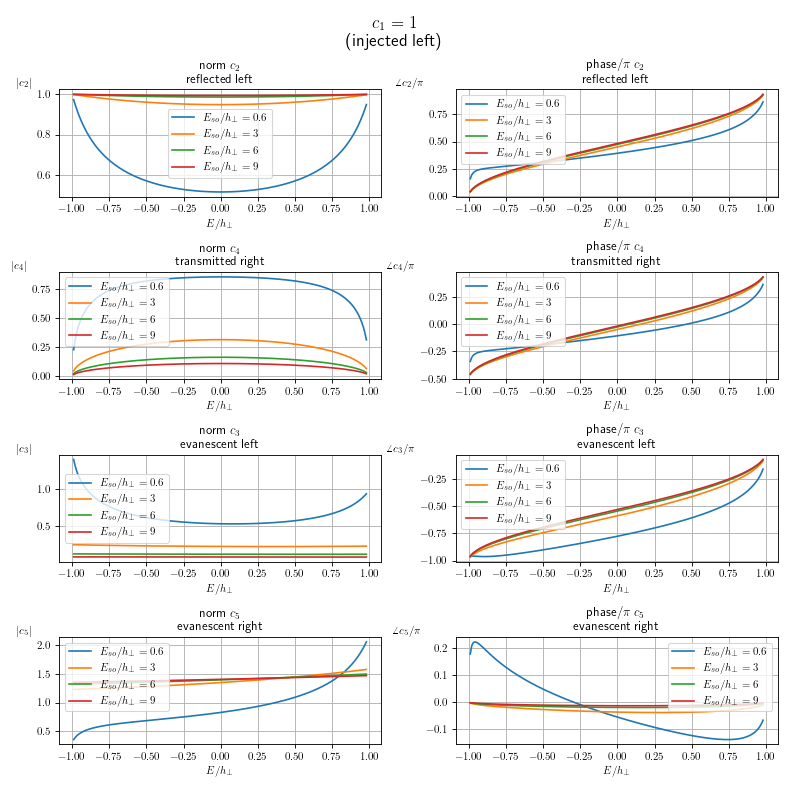

In [112]:
%matplotlib notebook
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(len(modes_ind), 2, figsize=(10, 10), dpi=100, tight_layout=True, facecolor='white')

for k in res.keys():
    for i in [0, 1]:
        axs[k[1] //2 -1 + k[1]%2 *2 , i].plot(r, res[k][i], label=fr"$$E_{{so}}/h_\perp = {k[0]}$$")
#         axs[k[1] //2 -1 + k[1]%2 *2 , i].grid(True)
#         axs[k[1] //2 -1 + k[1]%2 *2 , i].legend()
    m = modes_dict[k[1]]
#     axs[k[1] //2 -1 + k[1]%2 *2 , 0].set_title(fr"norm $c_{{k[1]}}$ \n ({modes_dict[k[1]]})")
    axs[k[1] //2 -1 + k[1]%2 *2 , 0].set_title(fr"norm $c_{k[1]}$ "+f"\n {m}")
    axs[k[1] //2 -1 + k[1]%2 *2 , 0].set_xlabel(r"$E/h_\perp$")
    axs[k[1] //2 -1 + k[1]%2 *2 , 0].set_ylabel(fr"$|c_{k[1]}|$", loc = 'top', rotation=0)

    axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_title(fr"phase/$\pi$ $c_{k[1]}$ "+f"\n {m}")
    axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_xlabel(r"$E/h_\perp$")
    axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_ylabel(fr"$\angle c_{k[1]}/\pi$", loc = 'top', rotation=0)


fig.suptitle(r"$c_{1}= 1$"+f"\n (injected left) ", fontsize=16)
for i in axs:
    for j in i:
        j.grid(True)
        j.legend()
             
# plt.savefig("wave function amplitude.pdf", transparent = False)
plt.show()

<IPython.core.display.Javascript object>


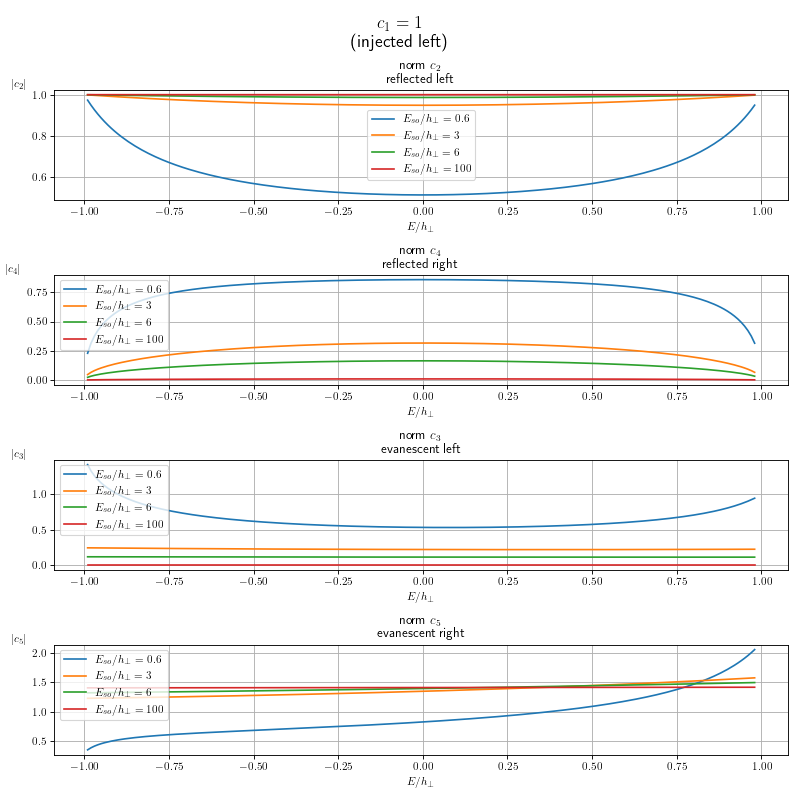

In [66]:
%matplotlib notebook
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(len(modes_ind), figsize=(10, 10), dpi=100, tight_layout=True, facecolor='white')

for k in res.keys():
    for i in [0]:
        axs[k[1] //2 -1 + k[1]%2 *2 ].plot(r, res[k][i], label=fr"$$E_{{so}}/h_\perp = {k[0]}$$")
#         axs[k[1] //2 -1 + k[1]%2 *2 , i].grid(True)
#         axs[k[1] //2 -1 + k[1]%2 *2 , i].legend()
    m = modes_dict[k[1]]
#     axs[k[1] //2 -1 + k[1]%2 *2 , 0].set_title(fr"norm $c_{{k[1]}}$ \n ({modes_dict[k[1]]})")
    axs[k[1] //2 -1 + k[1]%2 *2].set_title(fr"norm $c_{k[1]}$ "+f"\n {m}")
    axs[k[1] //2 -1 + k[1]%2 *2].set_xlabel(r"$E/h_\perp$")
    axs[k[1] //2 -1 + k[1]%2 *2].set_ylabel(fr"$|c_{k[1]}|$", loc = 'top', rotation=0)

#     axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_title(fr"phase/$\pi$ $c_{k[1]}$ "+f"\n {m}")
#     axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_xlabel(r"$E/h_\perp$")
#     axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_ylabel(fr"$\angle c_{k[1]}/\pi$", loc = 'top', rotation=0)


fig.suptitle(r"$c_{1}= 1$"+f"\n (injected left) ", fontsize=16)
for i in axs:
    i.grid(True)
    i.legend()
             
# plt.savefig("wave function amplitude.pdf", transparent = False)
plt.show()

# Rashba | Zeeman interface

## wave function

In [11]:
ee = 0
# ee = 0

al_r = 3
alpha = [al_r, 0]

profile = [0]

junction = RachbaJunction([profile, alpha])
S = junction.get_scattering_matrix(ee)

def b_region_WF(x, E, a = [1, 0]):
    # left part
    if x <= junction.interface[0]:
        junction.E_so = junction.alpha_profile[0]
        wf = junction.get_WF(x, E)
        injected = a[0]*wf[:, 0]
        reflected = np.dot(S.C[:2,:], np.array(a))[0]*wf[:, 1]
        evanescent = np.dot(S.C[2:, :], np.array(a))[0]*wf[:, 2]
    elif x > junction.interface[0]:
        junction.E_so = junction.alpha_profile[1]    
        wf = junction.get_WF(x, E)
        injected = a[1]*wf[:, 1]
        reflected = np.dot(S.C[:2,:], np.array(a))[1]*wf[:, 0]
        evanescent = np.dot(S.C[2:, :], np.array(a))[1]*wf[:, 3]
    return injected + reflected + evanescent

    
real_1 = []
imag_1 = []

real_2 = []
imag_2 = []

x_range = np.arange(-10, 15, 0.01)
# x_range = np.arange(-2.5, 2.5, 0.001)
for xx in x_range:
    r = b_region_WF(xx, ee)
    real_1.append(r[0].real)
    real_2.append(r[1].real)
    
    imag_1.append(r[0].imag)
    imag_2.append(r[1].imag)

<IPython.core.display.Javascript object>


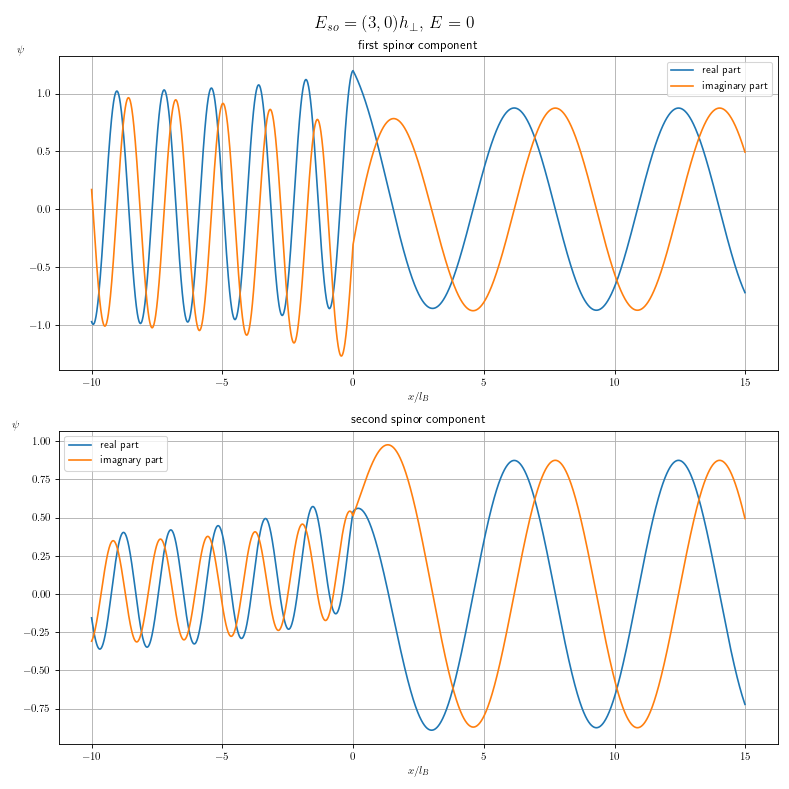

In [12]:
%matplotlib notebook

plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(2, 1, figsize=(10, 10), dpi=100, tight_layout=True, facecolor='white')

axs[0].plot(x_range, real_1, label="real part")
axs[0].plot(x_range, imag_1, label="imaginary part")
axs[0].set_title("first spinor component")

axs[0].set_xlabel(r"$x/l_B$")
axs[0].set_ylabel(r"$\psi$", loc = 'top', rotation=0)

axs[1].plot(x_range, real_2, label="real part")
axs[1].plot(x_range, imag_2, label="imagnary part")
axs[1].set_title("second spinor component")

axs[1].set_xlabel(r"$x/l_B$")
axs[1].set_ylabel(r"$\psi$", loc = 'top', rotation=0)

# axs[2].plot(x_range, [i+j for i, j in zip(imag_1, imag_2)], label="phase sum")
# axs[2].plot(x_range, [i+j for i, j in zip(real_1, real_2)], label="norm sum")

fig.suptitle(fr"$$E_{{so}}= ({alpha[0]}, {alpha[1]}) h_\perp, \, E = {ee}$$", fontsize=16)

for i in axs:
    i.legend()
    i.grid(True)
    
plt.savefig("wave function(Rashba|Zeeman).pdf", transparent = False)
plt.show()

## trasmissiona coefficient

In [15]:
ee = 0

al_r = 100
alpha = [al_r, 0]

profile = [0]

junction = RachbaJunction([profile, alpha])

def trasmiission(ee, par):
    junction.alpha_profile = [par, 0]
    S = junction.get_scattering_matrix(ee)
    if not S.is_unitary:
        return np.nan
    else:
        return S.t_coef

r = np.arange(-0.999, 1, 0.01)
eso = [0.6, 3, 6, 200]
res = make_grid(r, eso, [trasmiission])

<IPython.core.display.Javascript object>


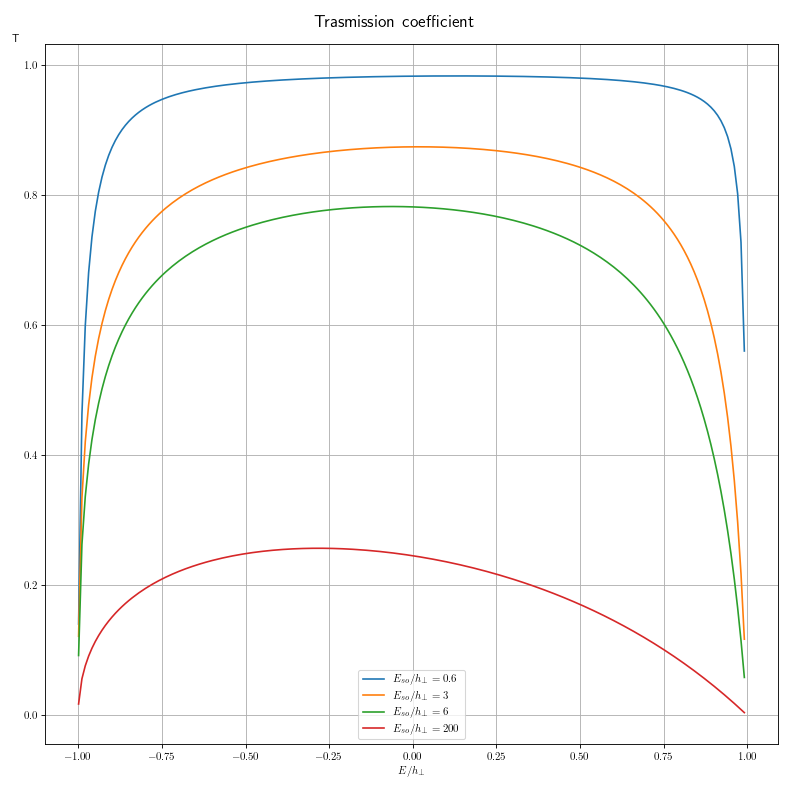

In [16]:
%matplotlib notebook
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(1, figsize=(10, 10), dpi=100, tight_layout=True, facecolor='white')

for k in res.keys():
    axs.plot(r, res[k][0], label=fr"$$E_{{so}}/h_\perp = {k}$$")
    
#     axs[k[1] //2 -1 + k[1]%2 *2 , 0].set_title(fr"norm $c_{k[1]}$ "+f"\n {m}")
    axs.set_xlabel(r"$E/h_\perp$")
    axs.set_ylabel("T", loc = 'top', rotation=0)

#     axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_title(fr"phase/$\pi$ $c_{k[1]}$ "+f"\n {m}")
#     axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_xlabel(r"$E/h_\perp$")
#     axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_ylabel(fr"$\angle c_{k[1]}/\pi$", loc = 'top', rotation=0)


fig.suptitle("Trasmission coefficient", fontsize=16)

axs.grid(True)
axs.legend()
             
# plt.savefig("Trasmission coefficient(Rashba|Zeeman).pdf", transparent = False)
plt.show()

## wave function components

In [6]:
ee = 0

al_r = 100
alpha = [al_r, 0]

profile = [0]

junction = RachbaJunction([profile, alpha])

def nrm(ee, par):
    junction.alpha_profile = [par[0], 0]
    S = junction.get_scattering_matrix(ee)
#     2 -> 0
#     3 -> 2
#     4 -> 1
#     5 -> 3
    return np.linalg.norm(S.C[par[1] //2 -1 + par[1]%2 *2 ,0])

def ngl(ee, par):
    junction.alpha_profile = [par[0], 0]
    S = junction.get_scattering_matrix(ee)
#     2 -> 0
#     3 -> 2
#     4 -> 1
#     5 -> 3
    return np.angle(S.C[par[1] //2 -1 + par[1]%2 *2 ,0])/np.pi

r = np.arange(-0.99, 0.99, 0.01)
eso = [0.6, 3, 6, 9]
modes_ind = [2, 3, 4, 5]
modes_dict = {2: "reflected left", 3: "evanescent left", 4: "transmitted right", 5: "evanescent right"}
par = list(itertools.product(eso, modes_ind))

res = make_grid(r, par, [nrm, ngl])

<IPython.core.display.Javascript object>


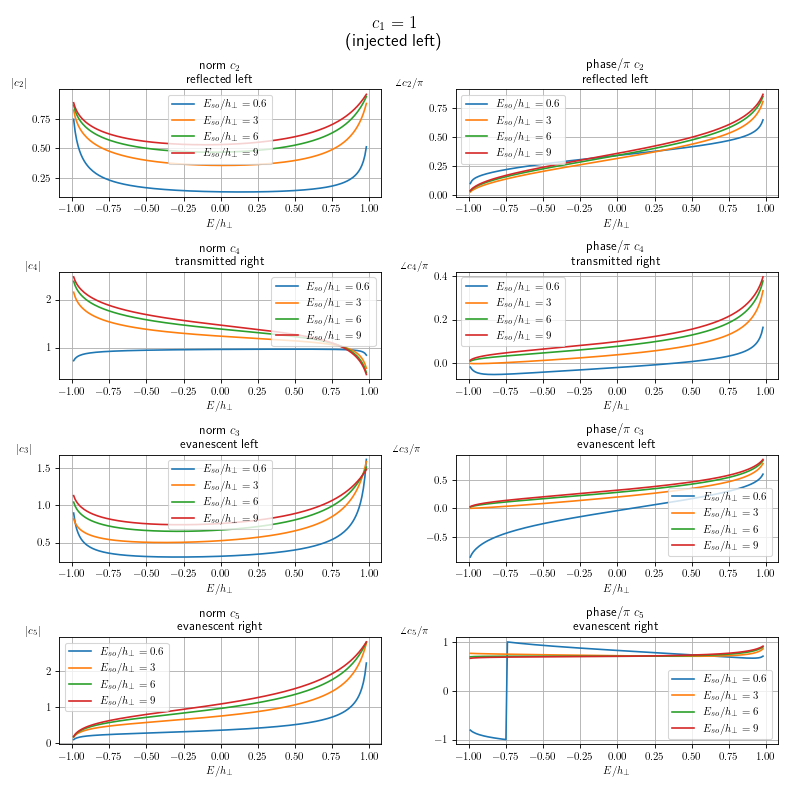

In [7]:
%matplotlib notebook
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(len(modes_ind), 2, figsize=(10, 10), dpi=100, tight_layout=True, facecolor='white')

for k in res.keys():
    for i in [0, 1]:
        axs[k[1] //2 -1 + k[1]%2 *2 , i].plot(r, res[k][i], label=fr"$$E_{{so}}/h_\perp = {k[0]}$$")
#         axs[k[1] //2 -1 + k[1]%2 *2 , i].grid(True)
#         axs[k[1] //2 -1 + k[1]%2 *2 , i].legend()
    m = modes_dict[k[1]]
#     axs[k[1] //2 -1 + k[1]%2 *2 , 0].set_title(fr"norm $c_{{k[1]}}$ \n ({modes_dict[k[1]]})")
    axs[k[1] //2 -1 + k[1]%2 *2 , 0].set_title(fr"norm $c_{k[1]}$ "+f"\n {m}")
    axs[k[1] //2 -1 + k[1]%2 *2 , 0].set_xlabel(r"$E/h_\perp$")
    axs[k[1] //2 -1 + k[1]%2 *2 , 0].set_ylabel(fr"$|c_{k[1]}|$", loc = 'top', rotation=0)

    axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_title(fr"phase/$\pi$ $c_{k[1]}$ "+f"\n {m}")
    axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_xlabel(r"$E/h_\perp$")
    axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_ylabel(fr"$\angle c_{k[1]}/\pi$", loc = 'top', rotation=0)


fig.suptitle(r"$c_{1}= 1$"+f"\n (injected left) ", fontsize=16)
for i in axs:
    for j in i:
        j.grid(True)
        j.legend()
             
# plt.savefig("wave function amplitude(Rashba|Zeeman)1.pdf", transparent = False)
plt.show()

<IPython.core.display.Javascript object>


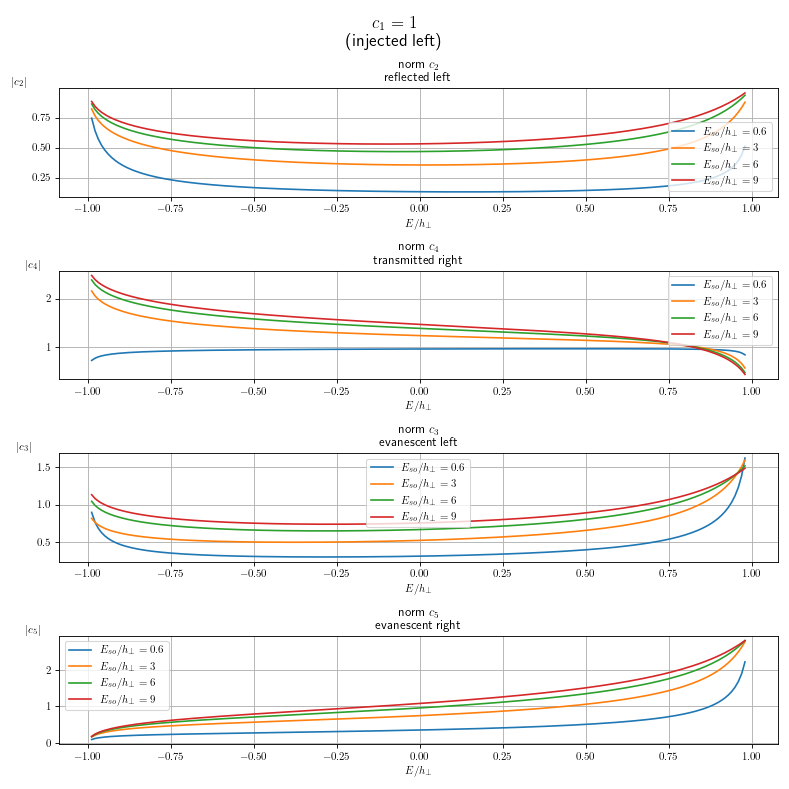

In [8]:
%matplotlib notebook
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(len(modes_ind), figsize=(10, 10), dpi=100, tight_layout=True, facecolor='white')

for k in res.keys():
    for i in [0]:
        axs[k[1] //2 -1 + k[1]%2 *2 ].plot(r, res[k][i], label=fr"$$E_{{so}}/h_\perp = {k[0]}$$")
#         axs[k[1] //2 -1 + k[1]%2 *2 , i].grid(True)
#         axs[k[1] //2 -1 + k[1]%2 *2 , i].legend()
    m = modes_dict[k[1]]
#     axs[k[1] //2 -1 + k[1]%2 *2 , 0].set_title(fr"norm $c_{{k[1]}}$ \n ({modes_dict[k[1]]})")
    axs[k[1] //2 -1 + k[1]%2 *2].set_title(fr"norm $c_{k[1]}$ "+f"\n {m}")
    axs[k[1] //2 -1 + k[1]%2 *2].set_xlabel(r"$E/h_\perp$")
    axs[k[1] //2 -1 + k[1]%2 *2].set_ylabel(fr"$|c_{k[1]}|$", loc = 'top', rotation=0)

#     axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_title(fr"phase/$\pi$ $c_{k[1]}$ "+f"\n {m}")
#     axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_xlabel(r"$E/h_\perp$")
#     axs[k[1] //2 -1 + k[1]%2 *2 , 1].set_ylabel(fr"$\angle c_{k[1]}/\pi$", loc = 'top', rotation=0)


fig.suptitle(r"$c_{1}= 1$"+f"\n (injected left) ", fontsize=16)
for i in axs:
    i.grid(True)
    i.legend()
             
# plt.savefig("wave function amplitude(Rashba|Zeeman)2.pdf", transparent = False)
plt.show()